Initially created by copilot.
GAN, CNN, directory of RGB images. Ideally needs lots of epochs

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset # Subset is used to create a subset of the dataset
from torchvision.utils import make_grid # make_grid is used to create a grid of images
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import ImageFolder

In [23]:
#global variables / parameters
batch_size = 2  # batch size
latent_dim = 32
channels = 3
img_size = 32
img_shape = (channels, img_size, img_size)

In [24]:

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),                 # Resize image
    transforms.ToTensor(),                                   # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load images from directory using ImageFolder
dataset = ImageFolder('D:/2024_My_AI_art/512x512_5step_FigureStudy', transform=transform)

# Create DataLoader (no labels required)
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         drop_last=True,
                                         shuffle=True)

print('\nDataloader Details:...\n')
print('Number of samples: ', len(dataloader.dataset))
print('Batch size: ', batch_size)
print('Number of batches: ', len(dataloader))

first_item = next(iter(dataloader))[0]     # Get first image tensor in the first batch
print('\nshape of first item in first batch: ',first_item.shape)

print('dataloader created')


Dataloader Details:...

Number of samples:  110
Batch size:  2
Number of batches:  55

shape of first item in first batch:  torch.Size([2, 3, 32, 32])
dataloader created


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ',device)

device:  cuda:0


In [26]:
# Define the generator and discriminator networks as CNNs

class G(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(G, self).__init__()
        self.init_size = img_shape[1] // 4  # 8 for 32x32 images
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim, 128 * self.init_size * self.init_size)
        )

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),  # 8x8 -> 16x16
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),  # 16x16 -> 32x32
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, img_shape[0], 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class D(nn.Module):
    def __init__(self, img_shape):
        super(D, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_shape[0], 32, 3, 2, 1),  # 32x32 -> 16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(32, 64, 3, 2, 1),            # 16x16 -> 8x8
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 128, 3, 2, 1),           # 8x8 -> 4x4
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(128, 256, 3, 1, 1),          # 4x4 -> 4x4
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
        )
        ds_size = img_shape[1] // 8  # 4 for 32x32 images
        self.adv_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * ds_size * ds_size, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        out = self.model(img)
        validity = self.adv_layer(out)
        return validity

# Initialize the generator and discriminator and move them to the device (GPU)
generator = G(latent_dim, img_shape).to(device)
discriminator = D(img_shape).to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0006, betas=(0.5, 0.99))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.99))

In [27]:
G_loss = [] #initialise losses
D_loss = []

In [32]:
# Training loop (can be re-run to train further)
# -------------
num_epochs = 50
for epoch in range(num_epochs):
    batch_G_loss = [] #initialise losses over batches
    batch_D_loss = []
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1, requires_grad=False).to(device)
        fake = torch.zeros(imgs.size(0), 1, requires_grad=False).to(device)

        # Configure input
        real_imgs = imgs.type(torch.FloatTensor).to(device)

        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        z = torch.randn(imgs.size(0), latent_dim).to(device)   # pure noise as generator input
        gen_imgs = generator(z)          # generate images from noise
        # g_loss measures generator's ability to fool the discriminator
        g_loss = criterion(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = criterion(discriminator(real_imgs), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        batch_G_loss.append(g_loss.item())
        batch_D_loss.append(d_loss.item())
        #end of batches loop
    D_loss.append(np.mean(batch_D_loss,axis=0))
    G_loss.append(np.mean(batch_G_loss,axis=0))
    if epoch%20==0 or epoch<=3:
      print(f"[epoch {epoch}/{num_epochs}] [d loss: {round(d_loss.item(),2)}] [g loss: {round(g_loss.item(),2)}]")
    #end of epoch loop

[epoch 0/50] [d loss: 0.7] [g loss: 0.67]
[epoch 1/50] [d loss: 0.73] [g loss: 0.65]
[epoch 1/50] [d loss: 0.73] [g loss: 0.65]
[epoch 2/50] [d loss: 0.7] [g loss: 0.66]
[epoch 2/50] [d loss: 0.7] [g loss: 0.66]
[epoch 3/50] [d loss: 0.64] [g loss: 0.74]
[epoch 3/50] [d loss: 0.64] [g loss: 0.74]
[epoch 20/50] [d loss: 0.7] [g loss: 0.63]
[epoch 20/50] [d loss: 0.7] [g loss: 0.63]
[epoch 40/50] [d loss: 0.74] [g loss: 0.54]
[epoch 40/50] [d loss: 0.74] [g loss: 0.54]


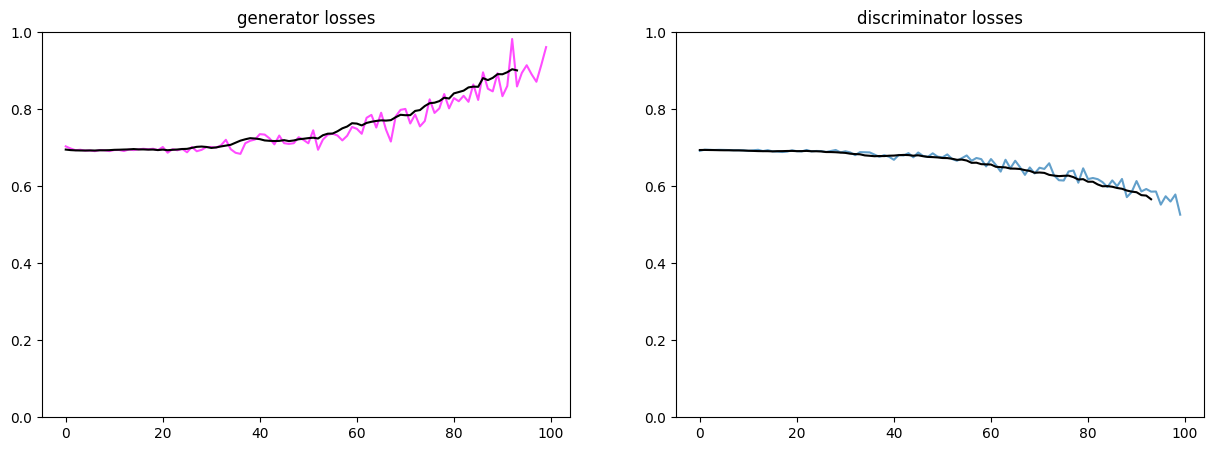

In [33]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w # options 'valid', 'same', 'full'

window_size = 7  # Choose a suitable window size

# Calculate moving averages
G_loss_smooth = moving_average(G_loss, window_size)
D_loss_smooth = moving_average(D_loss, window_size)

# Plot losses
fig, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].plot(G_loss,alpha=0.7,color='magenta')
ax[0].plot(G_loss_smooth, color='black')
ax[0].set_ylim([0,1])
ax[0].set_title('generator losses')

ax[1].plot(D_loss,alpha=0.7)
ax[1].plot(D_loss_smooth, color='black')
ax[1].set_ylim([0,1])
ax[1].set_title('discriminator losses')

plt.show()

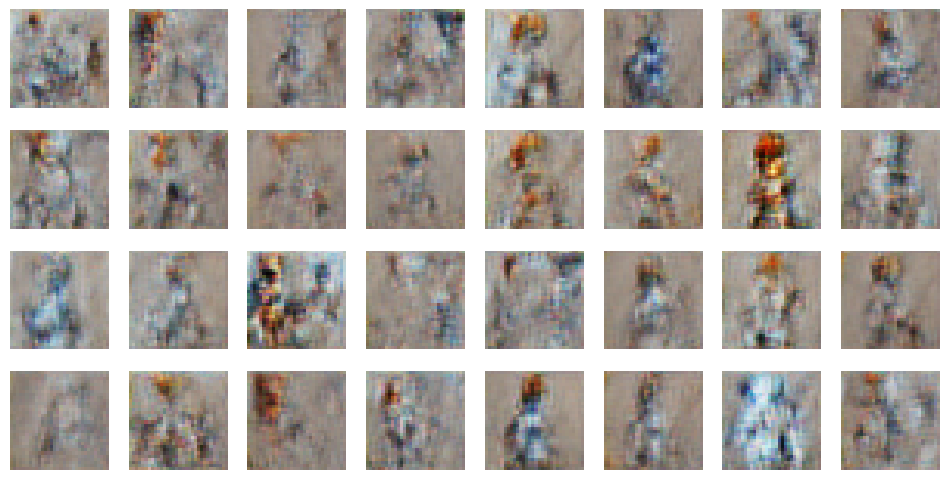

In [34]:
# Generate samples from the trained generator
with torch.no_grad():
    z = torch.randn(32, latent_dim).to(device)
    generated_samples = generator(z).view(-1, channels, img_size, img_size).permute(0, 2, 3, 1).cpu().numpy()

# Display generated samples
fig, axes = plt.subplots(4, 8, figsize=(12, 6)) #note: plt.subplots(rows,cols) but figsize is width/height
for i, ax in enumerate(axes.flat):
    ax.imshow((generated_samples[i] + 1) / 2)  # un-normalise to [0, 1]
    ax.axis('off')
plt.show()

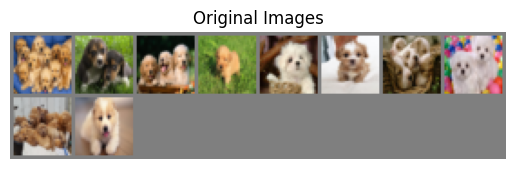

In [20]:
# ALTERNATIVE 1 - Using directory of images

#reset the dataloader
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

images, _ = next(iter(dataloader))     # Get first batch of images from dataloader

# Create grid of images
grid = make_grid(images, nrow=8) # nrow is the number of images per row (default is 8)

# Display grid of images
plt.imshow((grid.permute(1, 2, 0) + 1) / 2) # un-normalise to [0, 1]
plt.axis('off')
plt.title('Original Images')
plt.show()